In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

!pip install gymnasium[all]

Selecting previously unselected package xvfb.
(Reading database ... 124016 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.13_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.13) ...
Setting up xvfb (2:1.19.6-1ubuntu4.13) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Starting virtual X frame buffer: Xvfb.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 879 kB 4.9 MB/s 
     |████████████████████████████████| 3.4 MB 41.1 MB/s 
     |████████████████████████████████| 1.2 MB 53.4 MB/s 
     |████████████████████████████████| 2.4 MB 60.3 MB/s 
     |████████████████████████████████| 13.7 MB 55.8 MB/s 
     |████████████████████████████████| 1.8 MB 49.4 MB/s 
     |████████████████████████████████| 388 kB 71.2 MB/s 
     |████████████████████████████████| 1.1 MB 70.3 MB/s 
     |████████████████████████████████| 4.2 MB 61.8 MB/s 
     |██████████

state vector dim:  8
n_actions: 4


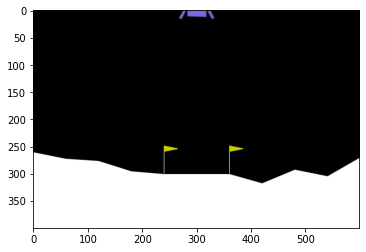

In [19]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#for gymnasium we declare rendermode in env creation rather than in env.render
env = gym.make("LunarLander-v2", render_mode="rgb_array")

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

#display initial point (can display properly using render_mode="human" if not using colab)
plt.imshow(env.render())
print("state vector dim: ", state_dim)
print("n_actions:", n_actions)



In [20]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(100,100),
    activation="tanh",
    solver="adam",
)

#env.reset returns a tuple in gymnasium
state_space = env.reset()[0]

#initialise agent to the dimension of state space and n_actions
agent.partial_fit([state_space] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(100, 100))

In [21]:
def generate_session(env, agent, t_max=1000):
  """
  play a single game using MLP agent
  terminate on game completion or after t_max steps
  """

  states, actions = [], []
  total_reward = 0

  s = env.reset()[0]

  for t in range(t_max):
    #input to predict proba is the state array
    probs = agent.predict_proba([s])
    probs = np.reshape(probs, (n_actions,))

    assert probs.shape == (env.action_space.n,) #make sure probabilities are a vector

    a = np.random.choice(n_actions, p=probs)

    #gymnasium adds truncated to env.step()
    new_s, r, done, truncated, info = env.step(a)

    states.append(s)
    actions.append(a)
    total_reward += r

    s = new_s
    if done:
      break
  return states, actions, total_reward

In [22]:
dummy_states, dummy_actions, dummy_reward = generate_session(env, agent, t_max=5)
print("states:", np.stack(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)

states: [[-0.00423346  1.4199045  -0.42881712  0.39929593  0.0049123   0.09713344
   0.          0.        ]
 [-0.00855665  1.4282994  -0.4394516   0.37306985  0.01196222  0.14101167
   0.          0.        ]
 [-0.01279716  1.4360907  -0.42906588  0.3462262   0.01692193  0.09920342
   0.          0.        ]
 [-0.01712341  1.4432722  -0.43982953  0.3190773   0.02404095  0.14239377
   0.          0.        ]
 [-0.02146282  1.4509397  -0.44116458  0.34063962  0.03117852  0.1427649
   0.          0.        ]]
actions: [1, 3, 1, 2, 2]
reward: -7.570525708370356


In [23]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=85):
    reward_threshold = np.percentile(rewards_batch, percentile)

    elite_states = [state for index in range(len(states_batch)) if rewards_batch[index] >= reward_threshold for state in states_batch[index]]
    elite_actions = [action for index in range(len(actions_batch)) if rewards_batch[index] >= reward_threshold for action in actions_batch[index]]

    return elite_states, elite_actions

In [24]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

mean reward = 165.810, threshold=262.206


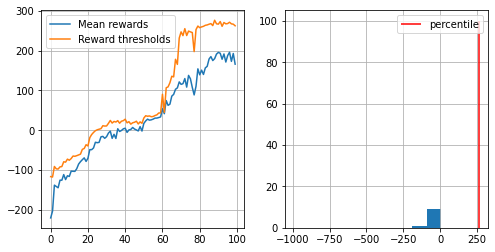

You Win! You may stop training now via KeyboardInterrupt.


In [25]:
n_sessions = 100
percentile = 70
log = []

for i in range(100):
    # generate new sessions
    sessions = [generate_session(env, agent) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    agent.partial_fit(elite_states, elite_actions)

    show_progress(rewards_batch, log, percentile)

    if np.mean(rewards_batch) > 50:
        print("You Win! You may stop training now via KeyboardInterrupt.")

(20,20) adam 65% threshold

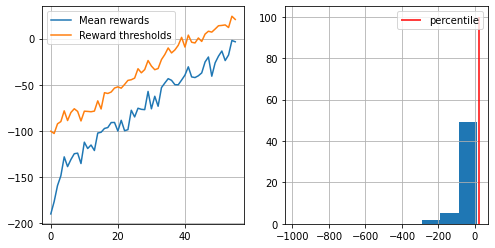

(100,100) adam 65% threshold

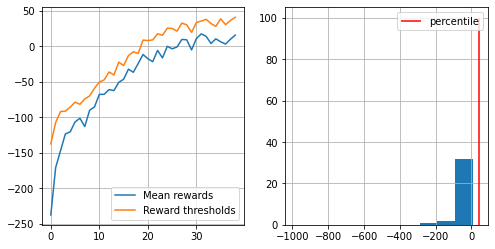